# Pharmaceutical drugs and vitamins Classification using Deep Convolutional Neural Networks and Transfer Learning

The dataset used includes images of popular pharmaceutical drugs and vitamins in the Philippines. This is a notebook that aims to classify these images using CNN and transfer learning.

**Important Note:** This notebook is not a part of a research study or peer-reviewed article that has been heavily reviewed and lawfully accepted by several medical institutions. The dataset was not reviewed by any Pharmaceutical authority or any practitioner that is knowledgeable with the field. The use of the dataset is encouraged for educational purposes only as it may impose ethical problems or may cause harm for others if improperly utilized. It is advised to not use this dataset for your own machine learning applications or services without prior peer-review by an expert in the field of medicine or any law making authority that is responsible for the ethical use of medical dataset. Please take this into consideration.

## Import Necessary Libraries 121



In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True) 

In [2]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [4]:
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [5]:
# System libraries
from pathlib import Path
import os.path

In [6]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [7]:
### We create a bunch of helpful functions throughout the course.
### Storing them here so they're easily accessible.

import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='Training_loss')
  plt.plot(epochs, val_loss, label='Validation_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='Training_Accuracy')
  plt.plot(epochs, val_accuracy, label='Validation_Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    colors = {'IUS4.DE': 'blue', 'DJSC.MI': 'green', 'BTC': 'red'}
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy',color=colors[c])
    plt.plot(total_val_acc, label='Validation Accuracy',color=colors[c])
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning',color=colors[c]) # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss',color=colors[c])
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning',color=colors[c]) # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

## Create helper functions

In [8]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# # Import series of helper functions for our notebook
# from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

## Load and transform data

In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [10]:
dataset = (r'C:\Users\Yogi\Desktop\Data Combined')
walk_through_dir(dataset)


There are 13 directories and 0 images in 'C:\Users\Yogi\Desktop\Data Combined'.
There are 0 directories and 1 images in 'C:\Users\Yogi\Desktop\Data Combined\121'.
There are 1 directories and 4 images in 'C:\Users\Yogi\Desktop\Data Combined\169'.
There are 1 directories and 0 images in 'C:\Users\Yogi\Desktop\Data Combined\169\training_logs'.
There are 1 directories and 0 images in 'C:\Users\Yogi\Desktop\Data Combined\169\training_logs\drug_classification'.
There are 2 directories and 0 images in 'C:\Users\Yogi\Desktop\Data Combined\169\training_logs\drug_classification\20230410-201231'.
There are 0 directories and 1 images in 'C:\Users\Yogi\Desktop\Data Combined\169\training_logs\drug_classification\20230410-201231\train'.
There are 0 directories and 1 images in 'C:\Users\Yogi\Desktop\Data Combined\169\training_logs\drug_classification\20230410-201231\validation'.
There are 0 directories and 1 images in 'C:\Users\Yogi\Desktop\Data Combined\201'.
There are 0 directories and 1000 images i

### Placing data into a Dataframe
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [11]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [12]:
image_df

,Filepath,Label
0,C:\Users\Yogi\Desktop\Data Combined\Alaxan\000...,Alaxan
1,C:\Users\Yogi\Desktop\Data Combined\Alaxan\000...,Alaxan
2,C:\Users\Yogi\Desktop\Data Combined\Alaxan\000...,Alaxan
3,C:\Users\Yogi\Desktop\Data Combined\Alaxan\000...,Alaxan
4,C:\Users\Yogi\Desktop\Data Combined\Alaxan\000...,Alaxan
...,...,...
19995,C:\Users\Yogi\Desktop\Data Combined\Neozep\000...,Neozep
19996,C:\Users\Yogi\Desktop\Data Combined\Neozep\000...,Neozep
19997,C:\Users\Yogi\Desktop\Data Combined\Neozep\000...,Neozep
19998,C:\Users\Yogi\Desktop\Data Combined\Neozep\000...,Neozep


### Visualizing images from the dataset

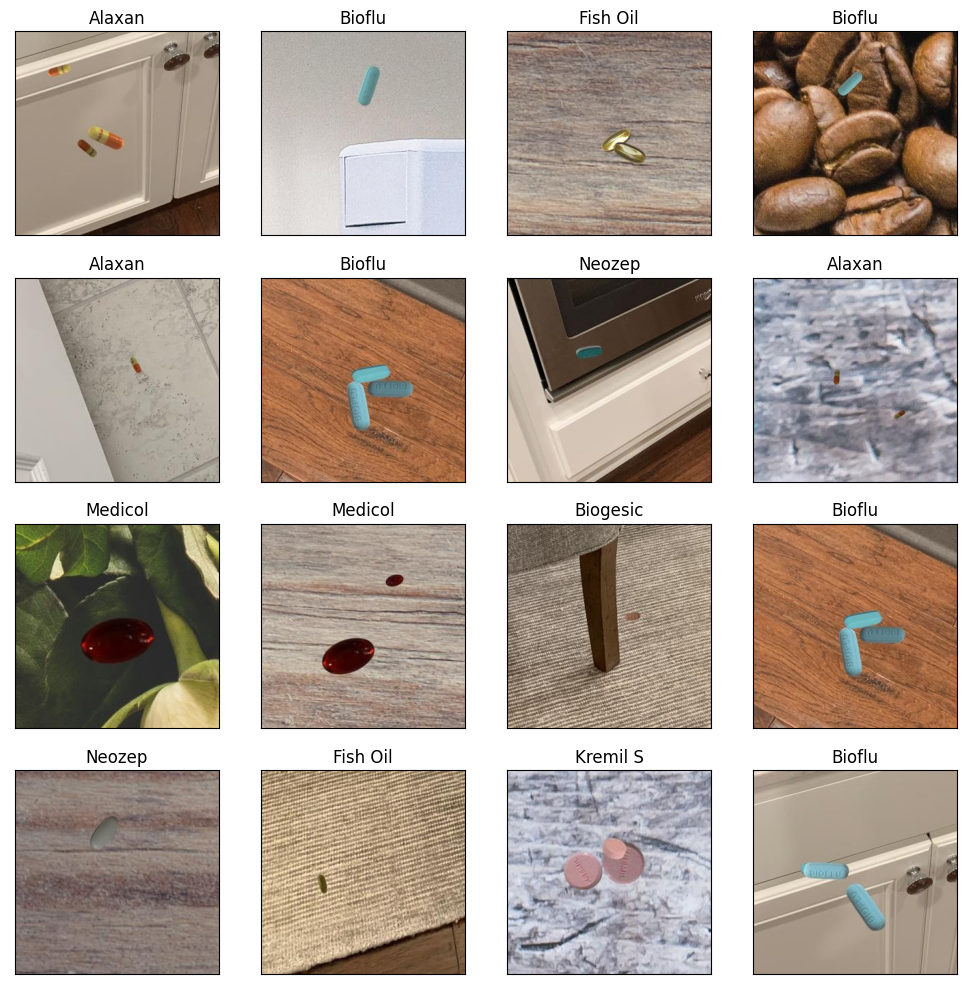

In [13]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

## Data Preprocessing
The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [14]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [15]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [16]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 12800 validated image filenames belonging to 10 classes.
Found 3200 validated image filenames belonging to 10 classes.
Found 4000 validated image filenames belonging to 10 classes.


In [17]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Training the model
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

**Batch size** : 32

**Epochs** : 100

**Input Shape** : (224, 224, 3)

**Output layer** : 10



In [18]:
# Load the pretained model
pretrained_model = tf.keras.applications.densenet.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=1000,
   
)
pretrained_model.trainable = False

29084464/29084464 [==============================] - 19s 1us/step


In [19]:
# Create checkpoint callback
checkpoint_path = "pharmaceutical_drugs_and_vitamins_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [20]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

### Training the model

In [21]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=300,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "drug_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/drug_classification/20230410-201845
Epoch 1/300
400/400 [==============================] - 185s 390ms/step - loss: 1.4552 - accuracy: 0.5259 - val_loss: 0.7332 - val_accuracy: 0.7987
Epoch 2/300
400/400 [==============================] - 151s 377ms/step - loss: 0.7445 - accuracy: 0.7633 - val_loss: 0.5187 - val_accuracy: 0.8428
Epoch 3/300
400/400 [==============================] - 152s 379ms/step - loss: 0.5723 - accuracy: 0.8106 - val_loss: 0.4376 - val_accuracy: 0.8628
Epoch 4/300
400/400 [==============================] - 154s 384ms/step - loss: 0.4770 - accuracy: 0.8411 - val_loss: 0.3817 - val_accuracy: 0.8791
Epoch 5/300
400/400 [==============================] - 149s 373ms/step - loss: 0.4084 - accuracy: 0.8651 - val_loss: 0.3452 - val_accuracy: 0.8866
Epoch 6/300
400/400 [==============================] - 152s 379ms/step - loss: 0.3566 - accuracy: 0.8813 - val_loss: 0.3157 - val_accuracy: 0.8972
Epoch 7/300
400/400 [==============

## Model Evaluation
The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:

**Precision(P)**: 
The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.

<center>$P=TP/(TP+FP)$</center>

**Recall(R)**: 
The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.
<center>$R=TP/(TP+FN)$</center>

**F1 score(F1)**: 
The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.
<center>$F1=2 * (TP * FP)/(TP+FP)$</center>



In [22]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.13269
Test Accuracy: 96.40%


### Visualizing loss curves

In [23]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


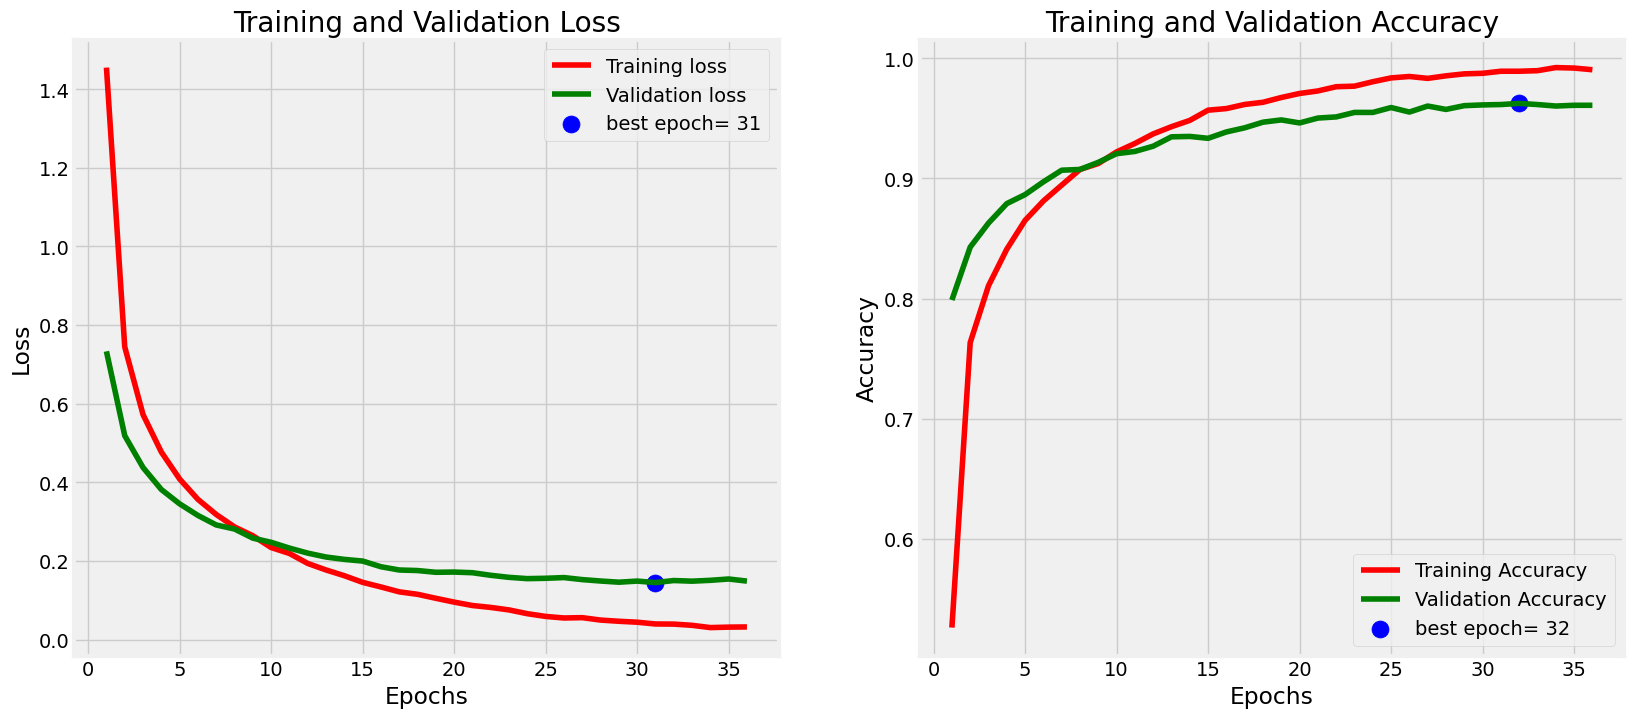

In [24]:
plot_training(history)

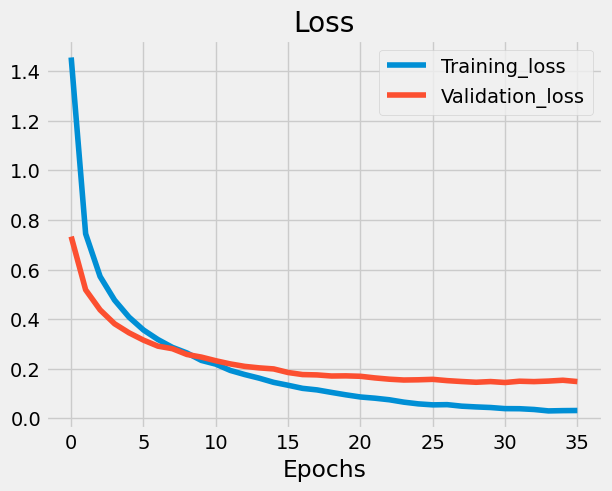

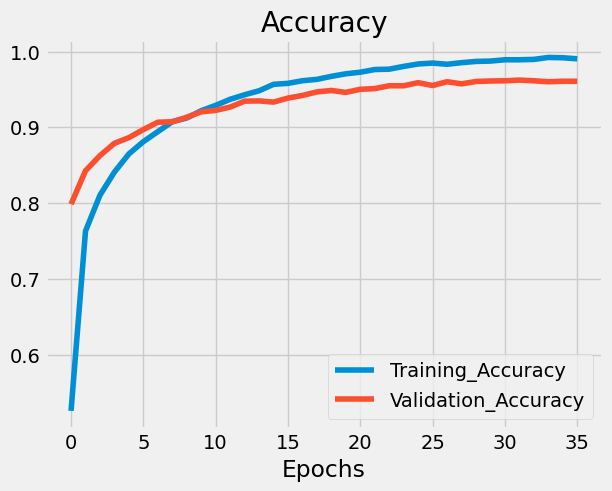

In [25]:
plot_loss_curves(history)

### Making predictions on the test data

In [26]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

125/125 [==============================] - 18s 122ms/step
The first 5 predictions: ['Alaxan', 'Bioflu', 'Medicol', 'Bactidol', 'Biogesic']


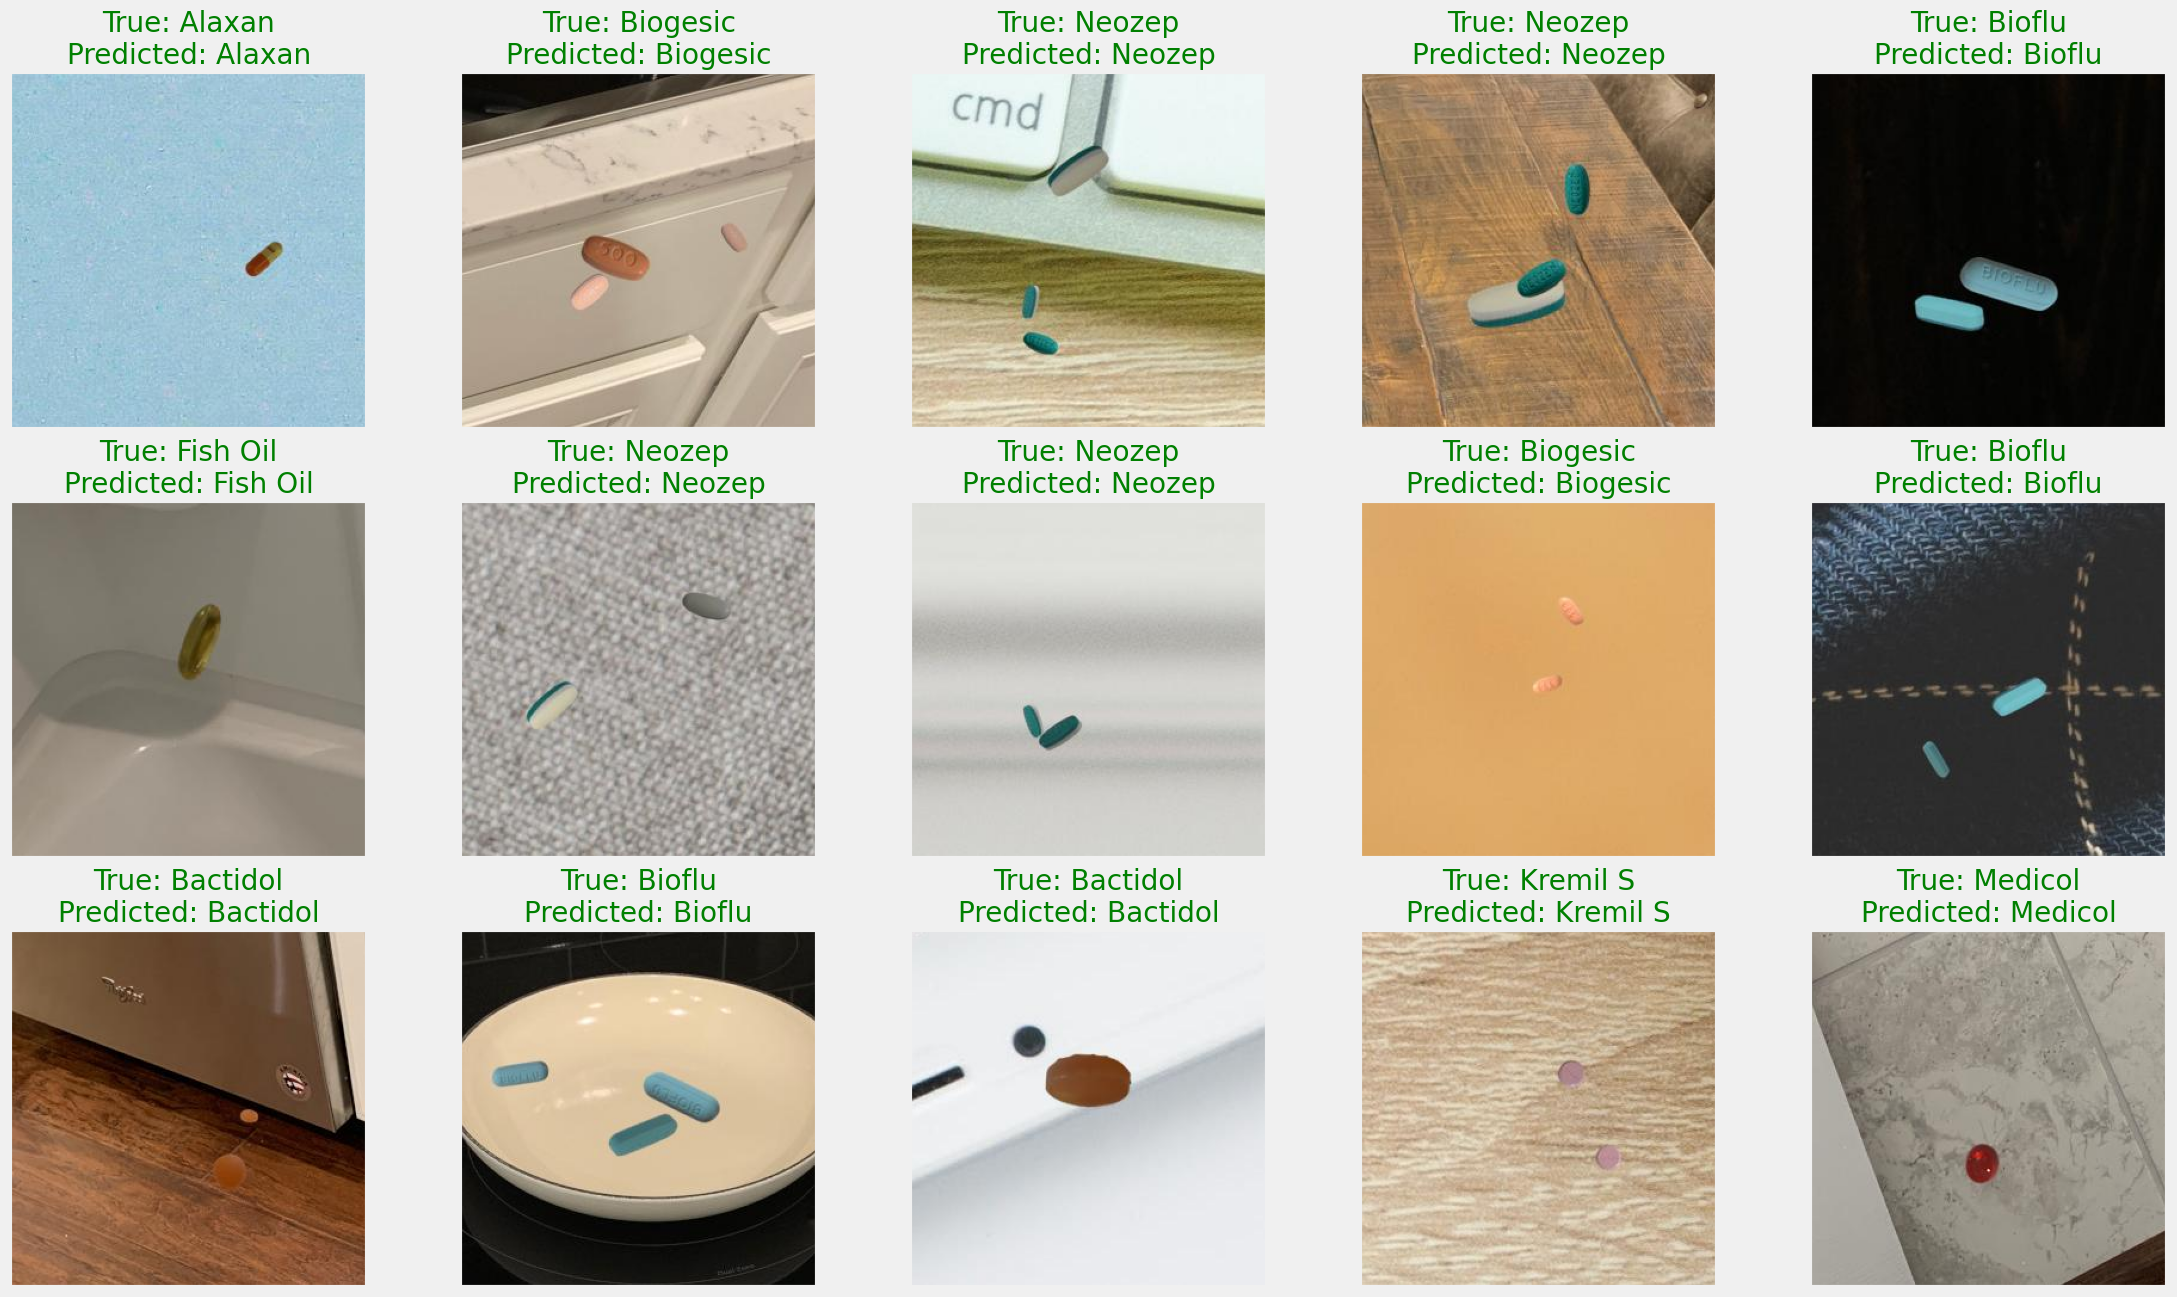

<Figure size 640x480 with 0 Axes>

In [27]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

### Plotting the classification reports and confusion matrix

In [28]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      Alaxan       0.96      0.97      0.97       367
    Bactidol       0.95      0.96      0.95       382
      Bioflu       0.96      0.98      0.97       430
    Biogesic       0.94      0.93      0.94       412
     DayZinc       0.96      0.99      0.97       408
    Decolgen       0.97      0.97      0.97       392
    Fish Oil       0.98      0.97      0.97       413
    Kremil S       0.98      0.95      0.96       402
     Medicol       1.00      0.98      0.99       402
      Neozep       0.95      0.93      0.94       392

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



In [29]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Alaxan,0.962162,0.970027,0.966079,367.000
Bactidol,0.950649,0.958115,0.954368,382.000
Bioflu,0.963470,0.981395,0.972350,430.000
Biogesic,0.936740,0.934466,0.935601,412.000
DayZinc,0.961814,0.987745,0.974607,408.000
Decolgen,0.969543,0.974490,0.972010,392.000
Fish Oil,0.975728,0.973366,0.974545,413.000
Kremil S,0.976923,0.947761,0.962121,402.000
Medicol,0.997462,0.977612,0.987437,402.000
Neozep,0.945736,0.933673,0.939666,392.000


In [30]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


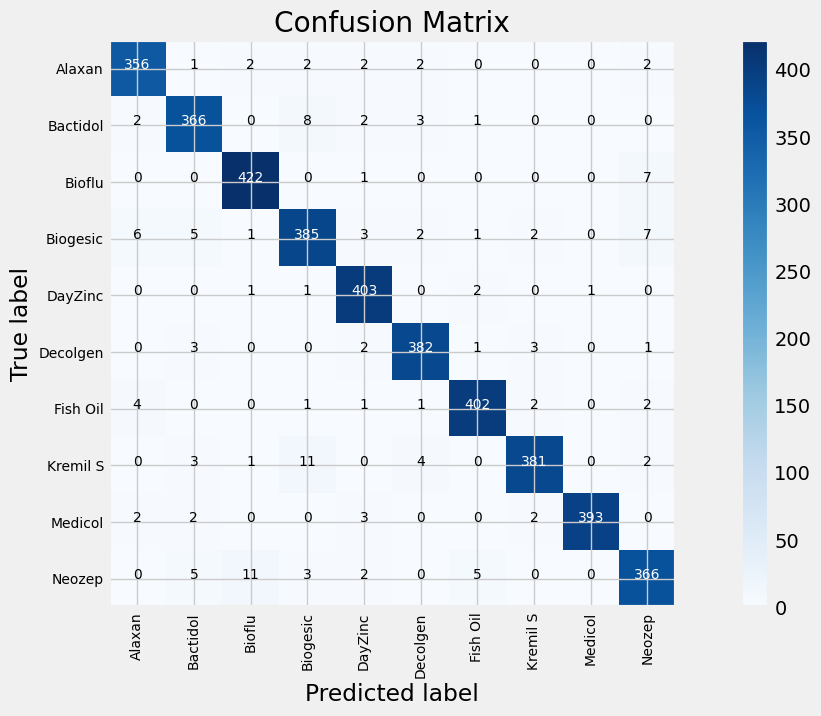

In [31]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [32]:
import joblib

In [33]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.13269
Test Accuracy: 96.40%
